In [1]:
%tb
import torch
import dataloader1
import numpy as np
import multiprocessing
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

No traceback available to show.


cuda:0


In [2]:
dataset = dataloader1.Loader(path="../data/"+'yelp2018')

1237259 interactions for training
324147 interactions for testing


In [3]:
g=dataset.getSparseGraph()
g

loading adjacency matrix
successfully loaded...


d:\python\GNN\LightGCN-PyTorch\LightGCN-PyTorch\code\dataloader1.py:332: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(index, data, torch.Size(coo.shape))


don't split the matrix


tensor(indices=tensor([[    0,     0,     0,  ..., 69714, 69715, 69715],
                       [    0, 31668, 31669,  ..., 69714, 31666, 69715]]),
       values=tensor([0.0526, 0.0096, 0.0662,  ..., 0.5000, 0.1443, 0.5000]),
       device='cuda:0', size=(69716, 69716), nnz=2544234,
       layout=torch.sparse_coo)

In [4]:
g[1].coalesce().indices()

tensor([[    1, 31668, 31686, 31687, 31688, 31689, 31690, 31691, 31692, 31693,
         31694, 31695, 31696, 31697, 31698, 31699, 31700, 31701, 31702, 31703,
         31704, 31705, 31706, 31707, 31708, 31709, 31710, 31711, 31712, 31713,
         31714, 31715, 31716, 31717, 31718, 31719, 31720, 31721, 31722, 31723,
         31724, 31725, 31726, 31727, 31728, 31729, 31730, 31731, 31732, 31733,
         31734, 31735, 31736, 31737, 31738, 31739, 31740, 31741, 31742, 31743,
         31744, 31745, 31746, 31747, 31748, 31749, 31750, 31751, 31752, 31753,
         31754, 31755, 31756, 31757, 31758, 31759, 31760, 31761, 31762, 31763,
         31764, 31765, 31766, 31767, 31768, 31769, 31770, 31771, 31772, 31773,
         31774, 31775, 31776, 31777, 31778, 31779, 31780, 31781, 31782, 31783,
         31784, 31785, 31786, 31787, 31788, 31789, 31790, 31791, 31792, 31793,
         31794, 31795, 31796, 31797, 31798, 31799, 31800, 31801, 31802, 31803,
         31804, 31805, 31806, 31807, 31808, 31809, 3

In [5]:
torch.zeros(1)

tensor([0.])

In [6]:
def UniformSample_original_python(dataset):
    """
    the original impliment of BPR Sampling in LightGCN
    :return:
        np.array
    """
    user_num = dataset.trainDataSize
    users = np.random.randint(0, dataset.n_users, user_num)
    allPos = dataset.allPos
    S = []
    for i, user in enumerate(users):
        posForUser = allPos[user]
        if len(posForUser) == 0:
            continue
        posindex = np.random.randint(0, len(posForUser))
        positem = posForUser[posindex]
        while True:
            negitem = np.random.randint(0, dataset.m_items)
            if negitem in posForUser:
                continue
            else:
                break
        S.append([user, positem, negitem])
    return np.array(S)
def minibatch(batch_size,*tensors):
    if len(tensors) == 1:
        tensor = tensors[0]
        for i in range(0, len(tensor), batch_size):
            yield tensor[i:i + batch_size]
    else:
        for i in range(0, len(tensors[0]), batch_size):
            yield tuple(x[i:i + batch_size] for x in tensors)

In [7]:
a=torch.Tensor([1,2,3,4,5,6,7,8,9])
a=a.reshape((3,3))
print(a)
q1,q2=a[:1],a[1:]
print(q1,q2)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
tensor([[1., 2., 3.]]) tensor([[4., 5., 6.],
        [7., 8., 9.]])


In [8]:
def set_seed(seed):
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    set_seed(2020)

In [9]:
p=torch.distributions.gumbel.Gumbel(0,1)
p.sample((10,))

tensor([ 0.5599, -1.0147,  1.4293,  2.7288,  0.0864,  0.1899,  0.3094,  0.5295,
        -0.5629,  0.8152])

In [10]:
a=torch.rand((1,4))
b=torch.Tensor([[2,2,2,2],[3,3,3,3]])
a=torch.nn.functional.gumbel_softmax(a,dim=1)
print(a)
torch.mul(a,b)

tensor([[0.0378, 0.0236, 0.0562, 0.8824]])


tensor([[0.0757, 0.0472, 0.1123, 1.7648],
        [0.1135, 0.0707, 0.1685, 2.6472]])

In [11]:
a=[[[1,2],[4,5]],[[6,5],[9,2]]]
a=torch.Tensor(a)
print(a)
torch.nn.functional.softmax(a,dim=0)

tensor([[[1., 2.],
         [4., 5.]],

        [[6., 5.],
         [9., 2.]]])


tensor([[[0.0067, 0.0474],
         [0.0067, 0.9526]],

        [[0.9933, 0.9526],
         [0.9933, 0.0474]]])

In [12]:
class LightGATLayer(torch.nn.Module):
    def __init__(self,dimi=1,dimo=1) -> None:
        super().__init__()
        self.dim=dimo
        self.L1=torch.nn.Linear(dimi,dimo)
        self.L2=torch.nn.Linear(dimi,dimo)
        self.L3=torch.nn.Linear(dimi,dimo)
        self.a = torch.nn.Parameter(torch.zeros(size=(2*dimo, 1)))
        self.leakyrelu = torch.nn.LeakyReLU(0.01)
        
    def forward(self,x,adj):
        # x=self.L(x)
        q=self.L1(x)
        k=self.L2(x)
        v=self.L3(x)
        n=x.shape[0]
        # a_i=torch.cat([x.repeat(1,n).view(n*n,-1),x.repeat(n, 1)], dim=1).view(n, -1, 2 * self.dim)
        # ei = self.leakyrelu(torch.matmul(a_i, self.a).squeeze(2))  # [N,N,1] -> [N,N]
        print(q.shape,k.shape)
        # a_i=torch.matmul(q,k.T)
        a_i=torch.zeros((n,n))
        ei=a_i
        zero=-9e15*torch.ones_like(ei)
        attention = torch.where(adj > 0, ei, zero)
        attention=torch.nn.functional.softmax(attention,dim=1)
        return torch.matmul(attention,v)

In [13]:
class LightGAT(torch.nn.Module):
    def __init__(self, dataset,dim=1,layer=3) -> None:
        super().__init__()
        self.layer=layer
        self.dim=dim
        self.dataset=dataset
        self.attn=[LightGATLayer(dim,dim).to(device) for _ in range(layer)]
        self.init_weight()
    def init_weight(self):
        self.user_num=self.dataset.n_users
        self.item_num=self.dataset.m_items
        self.user_embed=torch.nn.Embedding(num_embeddings=self.user_num,embedding_dim=self.dim)
        self.item_embed=torch.nn.Embedding(num_embeddings=self.item_num,embedding_dim=self.dim)
        torch.nn.init.normal_(self.user_embed.weight,std=0.1)
        torch.nn.init.normal_(self.item_embed.weight,std=0.1)
        self.Graph = self.dataset.getSparseGraph()
    def propagate(self):
        user_w=self.user_embed.weight
        item_w=self.item_embed.weight
        all_w=torch.concat([user_w,item_w],dim=0)
        all_w=all_w.to(device)
        res=[all_w]
        print('attn begin')
        for i in range(self.layer):
            all_w=self.attn[i](all_w,self.Graph)
            print('attn{i}')
            res.append(all_w)
        output=torch.stack(res,dim=1)
        output=torch.mean(output,dim=1)
        return output
    def train_step(self,u,i,j,decay,opt,T=1):
        output=self.propagate()
        user,item=(output[:self.user_num],output[self.user_num:])
        um=user[u]
        im=item[i]
        jm=item[j]
        score_ui=torch.mul(um,im)
        score_ui=torch.sum(score_ui,dim=1)
        score_uj=torch.mul(um,jm)
        score_uj=torch.sum(score_uj,dim=1)
        loss=torch.mean(torch.nn.functional.softplus(score_uj-score_ui))
        #L2
        u0=self.user_embed(u)
        i0=self.item_embed(i)
        j0=self.item_embed(j)
        L2=(u0.norm(2).pow(2)+i0.norm(2).pow(2)+j0.norm(2).pow(2))/(2*(float(len(u))))
        loss=loss+decay*L2
        opt.zero_grad()
        loss.backward()
        opt.step()
        return loss.cpu().item()
    @torch.no_grad
    def forward(self,u,T):
        output=self.propagate()
        print('propagate finish')
        user,item=(output[:self.user_num],output[self.user_num:])
        um=user[u]
        score=torch.matmul(um,item.t())
        return score

In [14]:
class feature_selective_layer(torch.nn.Module):
    
    def __init__(self,layer, input_dim, output_dim, start_temp=10.0, min_temp=0.1):
        super(feature_selective_layer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.start_temp = start_temp
        self.min_temp = min_temp
        self.layer=layer
        
        self.temp = torch.nn.Parameter(torch.Tensor([self.start_temp]), requires_grad=False)
        self.logits = torch.nn.Parameter(torch.Tensor(self.input_dim, self.output_dim), requires_grad=True)
        torch.nn.init.xavier_normal_(self.logits)
        
    def forward(self, X,T):
        uniform = torch.rand(self.logits.shape) * (1.0 - 1e-8) + 1e-8
        gumbel = -torch.log(-torch.log(uniform)).to(torch.device("cuda")) # avoid numerical instability
        self.temp.data = torch.max(self.temp * T, torch.tensor(self.min_temp))
        noisy_logits = (self.logits + gumbel) / self.temp
        samples = torch.nn.functional.softmax(noisy_logits,dim=0)
        X=torch.transpose(X,0,1)
        Y=torch.matmul(X.float(), samples)
        return Y

In [15]:
class LightGCN(torch.nn.Module):
    def __init__(self, dataset,dim=1,layer=3) -> None:
        super().__init__()
        self.layer=layer
        self.dim=dim
        self.dataset=dataset
        self.L=torch.nn.Linear(dim*(self.layer+1),dim)
        self.norm1=torch.nn.LayerNorm(dim*2)
        self.norm2=torch.nn.LayerNorm(dim)
        self.norm3=torch.nn.LayerNorm(dim)
        self.Relu=torch.nn.ReLU()
        self.MH=[]
        self.L1=[]
        self.L2=[]
        self.L3=[]
        self.L4=[]
        self.W=[]
        for i in range(layer):
            self.W.append(torch.nn.Linear(self.dim,self.dim).to(device))
        for i in range(5):
            self.L1.append(torch.nn.Linear(self.dim,self.dim*2).to(device))
            self.L2.append(torch.nn.Linear(self.dim,self.dim*2).to(device))
            self.L3.append(torch.nn.Linear(self.dim,self.dim*2).to(device))
            self.L4.append(torch.nn.Linear(self.dim*2,self.dim).to(device))
            self.MH.append(torch.nn.MultiheadAttention(self.dim*2,8).to(device))
            torch.nn.init.normal_(self.L1[i].weight,std=0.1)
            torch.nn.init.normal_(self.L2[i].weight,std=0.1)
            torch.nn.init.normal_(self.L3[i].weight,std=0.1)
            torch.nn.init.normal_(self.L4[i].weight,std=0.1)
            
        self.feature_selectiveu=feature_selective_layer(layer,self.dim,self.dim,5,0.5)
        self.feature_selectivei=feature_selective_layer(layer,self.dim,self.dim,5,0.5)
        self.feature_selectivej=feature_selective_layer(layer,self.dim,self.dim,5,0.5)
        self.init_weight()
    def init_weight(self):
        self.user_num=self.dataset.n_users
        self.item_num=self.dataset.m_items
        self.user_embed=torch.nn.Embedding(num_embeddings=self.user_num,embedding_dim=self.dim)
        self.item_embed=torch.nn.Embedding(num_embeddings=self.item_num,embedding_dim=self.dim)
        # self.user_cls=torch.nn.Parameter(torch.Tensor(1),requires_grad=True)
        # self.item_cls=torch.nn.Parameter(torch.Tensor(1),requires_grad=True)
        torch.nn.init.normal_(self.user_embed.weight,std=0.1)
        torch.nn.init.normal_(self.item_embed.weight,std=0.1)
        # torch.nn.init.normal_(self.user_cls,std=0.1)
        # torch.nn.init.normal_(self.item_cls,std=0.1)
        self.Graph = self.dataset.getSparseGraph()
        # self.gumbel=torch.nn.Parameter(torch.rand(1,self.layer+1,1))
        
    def propagate(self,user_w,item_w,T):
        n=user_w.shape[0]
        user=[]
        for i in range(5):
            x=user_w[n//5*i:n//5*(i+1)]
            q=self.L1[i](x)
            k=self.L2[i](x)
            v=self.L3[i](x)
            y=self.MH[i](q,k,v)[0]
            user.append(self.L4[i](y))
        user.append(user_w[n//5*(i+1):])
        user=torch.concat(user,dim=0)
        user_w=user_w+user
        all_w=torch.concat([user_w,item_w],dim=0)
        all_w=all_w.to(device)
        w_layers=[all_w]
        # origin=all_w
        for i in range(self.layer): 
            all_w=torch.sparse.mm(self.Graph,all_w)
            # all_w=0.3*origin+0.7*all_w
            # all_w=self.W[i](all_w)
            # all_w=self.Relu(all_w)
            w_layers.append(all_w)
        w_layers=torch.stack(w_layers,dim=1)
        #Gumbel
        # gumbel_softmax=torch.nn.functional.gumbel_softmax(self.gumbel,tau=T,dim=1)
        # gumbel_softmax=torch.Tensor([0.3,0.3,0.2,0.2])
        # gumbel_softmax=gumbel_softmax.reshape(1,-1,1)
        # gumbel_softmax=gumbel_softmax.to(device)
        # output=torch.mul(w_layers,gumbel_softmax)
        # output=output.sum(dim=1)
        # output=torch.mean(w_layers,dim=1)
        # output=[]
        # for i in range(50):
        #     output.append(self.feature_selective[i](w_layers,T))
        # output=torch.stack(output,dim=1)
        # output=self.feature_selective(w_layers,T)
        # output=self.MH(w_layers,w_layers,w_layers)
        output=torch.mean(w_layers,dim=1)
        # w_layers=torch.reshape(w_layers,(-1,self.dim*(self.layer+1)))
        # output=self.L(w_layers)

        # n=user_w.shape[0]
        # user_w=output[:n]
        # item_w=output[n:]
        # user=[]
        # for i in range(5):
        #     x=user_w[n//5*i:n//5*(i+1)]
        #     q=self.L1[i](x)
        #     k=self.L2[i](x)
        #     v=self.L3[i](x)
        #     y=self.MH[i](q,k,v)[0]
        #     user.append(self.L4[i](y))
        # user.append(user_w[n//5*(i+1):])
        # user=torch.concat(user,dim=0)
        # user_w=user_w+user
        # output=torch.concat([user_w,item_w],dim=0)
        return output
    def train_step(self,u,i,j,decay,opt,T=1):
        user_w=self.user_embed.weight
        item_w=self.item_embed.weight
        # user_w[u]=user_w[u]+self.u_cls
        # item_w[i]=item_w[i]+self.i_cls
        # item_w[j]=item_w[j]+self.j_cls
        output=self.propagate(user_w,item_w,T)
        user,item=(output[:self.user_num],output[self.user_num:])
        # user_=[]
        # n=user.shape[0]
        # for k in range(5):
        #     user_.append(self.MH[k](user[n//5*k:n//5*(k+1)],\
        #                     user[n//5*k:n//5*(k+1)],user[n//5*k:n//5*(k+1)])[0])
        # user_.append(user[n//5*(k+1):])
        # user=torch.concat(user_,dim=0)
        um=user[u]
        im=item[i]
        jm=item[j]
        score_ui=torch.mul(um,im)
        score_ui=torch.sum(score_ui,dim=1)
        score_uj=torch.mul(um,jm)
        score_uj=torch.sum(score_uj,dim=1)
        #add
        # score_punish=torch.nn.functional.sigmoid(score_ui)
        loss=torch.mean(torch.nn.functional.softplus(score_uj-score_ui))

        #L2
        u0=self.user_embed(u)
        i0=self.item_embed(i)
        j0=self.item_embed(j)
        L2=(u0.norm(2).pow(2)+i0.norm(2).pow(2)+j0.norm(2).pow(2))/(2*(float(len(u))))
        # L2=(u0.norm(1)+i0.norm(1)+j0.norm(1))/(2*(float(len(u))))
        
        loss=loss+decay*L2
        opt.zero_grad()
        loss.backward()
        opt.step()
        return loss.cpu().item()
    @torch.no_grad
    def forward(self,u,T):
        user_w=self.user_embed.weight
        item_w=self.item_embed.weight
        output=self.propagate(user_w,item_w,T)
        user,item=(output[:self.user_num],output[self.user_num:])
        um=user[u]
        score=torch.matmul(um,item.t())
        return score


In [16]:
lgcn=LightGCN(dataset,64,3)
lgcn=lgcn.to(device)


loading adjacency matrix


In [17]:
lgcn(1,1).shape

torch.Size([38048])

In [18]:
def shuffle(*arrays, **kwargs):

    require_indices = False

    if len(set(len(x) for x in arrays)) != 1:
        raise ValueError('All inputs to shuffle must have '
                         'the same length.')

    shuffle_indices = np.arange(len(arrays[0]))
    np.random.shuffle(shuffle_indices)

    if len(arrays) == 1:
        result = arrays[0][shuffle_indices]
    else:
        result = tuple(x[shuffle_indices] for x in arrays)

    if require_indices:
        return result, shuffle_indices
    else:
        return result


In [19]:
def getLabel(test_data, pred_data):
    r = []
    for i in range(len(test_data)):
        groundTrue = test_data[i]
        predictTopK = pred_data[i]
        pred = list(map(lambda x: x in groundTrue, predictTopK))
        pred = np.array(pred).astype("float")
        r.append(pred)
    return np.array(r).astype('float')

def NDCGatK_r(test_data,r,k):
    """
    Normalized Discounted Cumulative Gain
    rel_i = 1 or 0, so 2^{rel_i} - 1 = 1 or 0
    """
    assert len(r) == len(test_data)
    pred_data = r[:, :k]

    test_matrix = np.zeros((len(pred_data), k))
    for i, items in enumerate(test_data):
        length = k if k <= len(items) else len(items)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = np.sum(max_r * 1./np.log2(np.arange(2, k + 2)), axis=1)
    dcg = pred_data*(1./np.log2(np.arange(2, k + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg/idcg
    ndcg[np.isnan(ndcg)] = 0.
    return np.sum(ndcg)

def RecallPrecision_ATk(test_data, r, k):
    """
    test_data should be a list? cause users may have different amount of pos items. shape (test_batch, k)
    pred_data : shape (test_batch, k) NOTE: pred_data should be pre-sorted
    k : top-k
    """
    right_pred = r[:, :k].sum(1)
    precis_n = k
    recall_n = np.array([len(test_data[i]) for i in range(len(test_data))])
    recall = np.sum(right_pred/recall_n)
    precis = np.sum(right_pred)/precis_n
    return {'recall': recall, 'precision': precis}

In [20]:
topks=20

def test_one_batch(X):
    sorted_items = X[0].numpy()
    groundTrue = X[1]
    r = getLabel(groundTrue, sorted_items)
    pre, recall, ndcg = [], [], []
    for k in [topks]:
        ret = RecallPrecision_ATk(groundTrue, r, k)
        pre.append(ret['precision'])
        recall.append(ret['recall'])
        ndcg.append(NDCGatK_r(groundTrue,r,k))
    return {'recall':np.array(recall), 
            'precision':np.array(pre), 
            'ndcg':np.array(ndcg)}


def Test(dataset, Recmodel, epoch,  multicore=0,T=1):
    u_batch_size = 1024
    testDict: dict = dataset.testDict
    Recmodel: LightGCN
    # eval mode with no dropout
    Recmodel = Recmodel.eval()
    max_K = topks
    if multicore == 1:
        pool = multiprocessing.Pool(10)
    results = {'precision': np.zeros(1),
               'recall': np.zeros(1),
               'ndcg': np.zeros(1)}
    with torch.no_grad():
        users = list(testDict.keys())
        try:
            assert u_batch_size <= len(users) / 10
        except AssertionError:
            print(f"test_u_batch_size is too big for this dataset, try a small one {len(users) // 10}")
        users_list = []
        rating_list = []
        groundTrue_list = []
        # auc_record = []
        # ratings = []
        total_batch = len(users) // u_batch_size + 1
        for batch_users in minibatch(u_batch_size,users):
            allPos = dataset.getUserPosItems(batch_users)
            groundTrue = [testDict[u] for u in batch_users]
            batch_users_gpu = torch.Tensor(batch_users).long()
            batch_users_gpu = batch_users_gpu.to(device)

            rating = Recmodel(batch_users_gpu,T)
            rating = rating.cpu()
            exclude_index = []
            exclude_items = []
            for range_i, items in enumerate(allPos):
                exclude_index.extend([range_i] * len(items))
                exclude_items.extend(items)
            rating[exclude_index, exclude_items] = -(1<<10)
            _, rating_K = torch.topk(rating, k=max_K)
            # rating = rating.cpu().numpy()
            # aucs = [ 
            #         utils.AUC(rating[i],
            #                   dataset, 
            #                   test_data) for i, test_data in enumerate(groundTrue)
            #     ]
            # auc_record.extend(aucs)
            del rating
            users_list.append(batch_users)
            rating_list.append(rating_K.cpu())
            groundTrue_list.append(groundTrue)
        assert total_batch == len(users_list)
        X = zip(rating_list, groundTrue_list)
        if multicore == 1:
            pre_results = pool.map(test_one_batch, X)
        else:
            pre_results = []
            for x in X:
                pre_results.append(test_one_batch(x))
        scale = float(u_batch_size/len(users))
        for result in pre_results:
            results['recall'] += result['recall']
            results['precision'] += result['precision']
            results['ndcg'] += result['ndcg']
        results['recall'] /= float(len(users))
        results['precision'] /= float(len(users))
        results['ndcg'] /= float(len(users))
        # results['auc'] = np.mean(auc_record)
        if multicore == 1:
            pool.close()
        print(results)
        return results

In [21]:
opt=torch.optim.Adam(lgcn.parameters(),0.001)

In [22]:
res=[]
recall=[]

In [23]:
S=UniformSample_original_python(dataset)
U=torch.Tensor(S[:,0]).long()
I=torch.Tensor(S[:,1]).long()
J=torch.Tensor(S[:,2]).long()
U=U.to(device)
I=I.to(device)
J=J.to(device)
U,I,J=shuffle(U,I,J)

In [24]:
for name, param in lgcn.named_parameters():
    if param.requires_grad:
        print(name,param.shape)


L.weight torch.Size([64, 256])
L.bias torch.Size([64])
norm1.weight torch.Size([128])
norm1.bias torch.Size([128])
norm2.weight torch.Size([64])
norm2.bias torch.Size([64])
norm3.weight torch.Size([64])
norm3.bias torch.Size([64])
feature_selectiveu.logits torch.Size([64, 64])
feature_selectivei.logits torch.Size([64, 64])
feature_selectivej.logits torch.Size([64, 64])
user_embed.weight torch.Size([31668, 64])
item_embed.weight torch.Size([38048, 64])


In [25]:

min_loss=100000

In [26]:
# p=torch.load('cp/max_real.pt')

In [27]:
# p=torch.load('cp/add.pt',map_location='cuda:0')

In [28]:
loss=torch.zeros(1)
for epoch in range(1,6001):
    loss=0.
    S=UniformSample_original_python(dataset)
    U=torch.Tensor(S[:,0]).long()
    I=torch.Tensor(S[:,1]).long()
    J=torch.Tensor(S[:,2]).long()
    U=U.to(device)
    I=I.to(device)
    J=J.to(device)
    U,I,J=shuffle(U,I,J)
    for batch,(u,i,j) in enumerate(minibatch(8192,U,I,J)):
        loss+=lgcn.train_step(u,i,j,1e-4,opt,0.1)
        # np.power(1/10,epoch/300)
    print(epoch,':',loss/batch)
    if epoch%5==0:
        p=Test(dataset, lgcn, 1,  multicore=0,T=0.1)
        recall.append(p['recall'])
    if min_loss>loss:
        min_loss=loss
        torch.save(lgcn,'cp/layer3_yelp.pt')
    res.append(loss/batch)
    

1 : 0.6030881738425881
2 : 0.31336547750116184
3 : 0.20793647560852252
4 : 0.1746496306547266
5 : 0.16004302130629686
{'precision': array([0.01580776]), 'recall': array([0.03341016]), 'ndcg': array([0.02735651])}
6 : 0.15323331685650426
7 : 0.14728342307521808
8 : 0.14369429430819505
9 : 0.14043072813394053
10 : 0.13581475832604414
{'precision': array([0.01666667]), 'recall': array([0.03570821]), 'ndcg': array([0.02910003])}
11 : 0.1330384866192641
12 : 0.12991529648864505
13 : 0.12616104223080818
14 : 0.12412563504170109
15 : 0.1210930770300082
{'precision': array([0.01739611]), 'recall': array([0.03736306]), 'ndcg': array([0.03051663])}
16 : 0.11790118519438814
17 : 0.11557333225643399
18 : 0.11153961244403132
19 : 0.10852745668777566
20 : 0.10560312018489205
{'precision': array([0.01843186]), 'recall': array([0.03967002]), 'ndcg': array([0.0323744])}
21 : 0.10395439576036883
22 : 0.10151090971286723
23 : 0.09947370431873183
24 : 0.09649561143276707
25 : 0.09515689584790477
{'precisi

KeyboardInterrupt: 

In [ ]:
max(recall)

array([0.05810623])

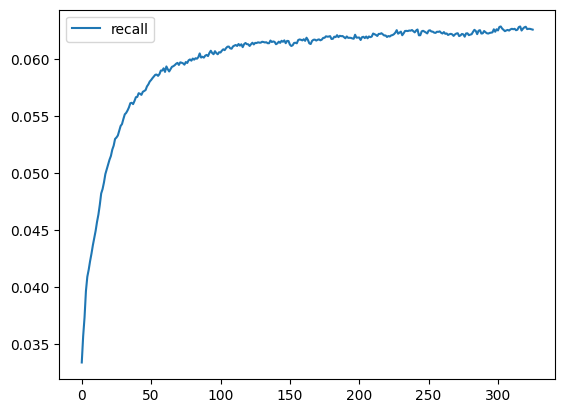

In [29]:
import matplotlib.pyplot as plt

# plt.plot(res,label='loss')
plt.plot(recall,label='recall')
plt.legend()
# plt.xticks(range(0,161,20),range(0,850,100))
plt.show()

In [30]:
p=torch.load('res/original_layer1.pt',map_location='cuda:0')

In [31]:
Test(dataset, p, 2,  multicore=0)
# torch.save(lgcn,'cp/MH_MIN_last.pt')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
